# Mobikwik

In [47]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import pandas as pd
import gensim
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 900
svg_renderer.height = 500
pio.renderers.default = "svg"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/fintech/mobikwik/mobikwik.csv')

In [25]:
# Company username
company_username = 'MobiKwikSWAT'

In [4]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [5]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [6]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [7]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [26]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [27]:
qdf.shape

(237, 28)

In [28]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 234


In [29]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [30]:
result = pd.DataFrame()
result['conversation_id'] = conversation_ids
result['response_time'] = 0

In [31]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
    result.at[index, 'response_time'] = response_time

In [32]:
result

,conversation_id,response_time
0,1343398089277595648,0.000000
1,1335260303009882112,0.000000
2,1333639022715944960,143.658889
3,1333048476918116352,0.000000
4,1333021985534668802,0.000000
...,...,...
229,1083275847778222080,0.000000
230,1082941120399560704,0.082500
231,1082865424310517761,27.335556
232,1082938998773989376,0.000000


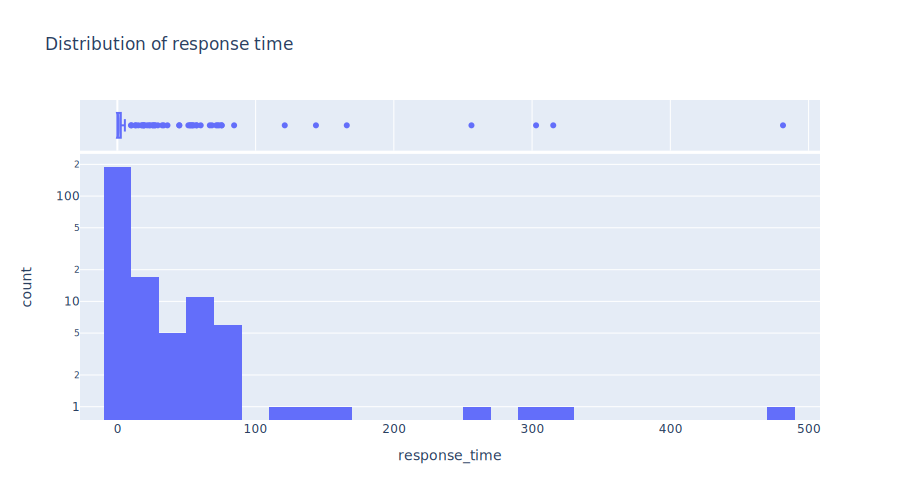

In [35]:
fig = px.histogram(result, x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

In [37]:
df[df['conversation_id'] == '1335260303009882112']

,tweet,conversation_id,date,hashtags,id,inReplyToTweetId,reply_to,language,likes_count,media,...,favourites_count,user_status_count,location,name,description,verified,url,user_id,username,is_query
1567,@Akshaynachankar We are glad that your issue h...,1335260303009882112,2020-12-08 03:46:00+00:00,NaN,1336155039874727937,1336005306766172160,https://twitter.com/Akshaynachankar,en,0,NaN,...,2718,232171,India,MobiKwik Support,Official Support handle of @MobiKwik | We're h...,True,https://www.mobikwik.com/help,3037981994,MobiKwikSWAT,2


https://twitter.com/MobiKwikSWAT/status/1343765688704331776

https://twitter.com/MobiKwikSWAT/status/1336155039874727937

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [38]:
result['resolution_time'] = 0

In [39]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[-1]['username'] == company_username:
        resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result.at[index, 'resolution_time'] = resolution_time

In [40]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 105
Number of queries unresolved: 129


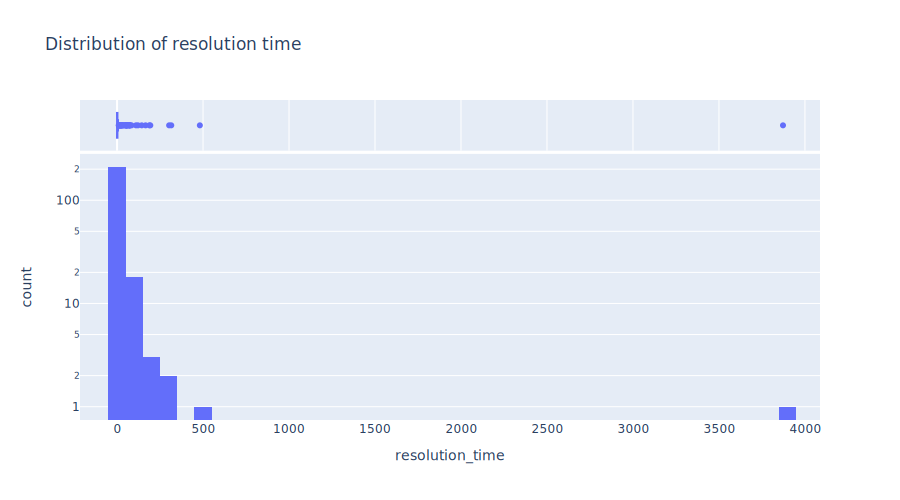

In [41]:
fig = px.histogram(result, x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [42]:
result.describe()

,response_time,resolution_time
count,234.000000,234.000000
mean,14.938972,31.573590
std,50.127574,257.168860
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.466319,2.240278
max,481.504167,3872.435000


## Query Tweets Topics


In [53]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[(queries['inReplyToTweetId'] == 'nan') & (queries['username'] != company_username)]
queries.shape


(116, 28)

In [54]:
processor = Processor('./../../data/config.json')
pre_queries, post_queries = processor.preprocess(queries)
pre_id2word = gensim.corpora.Dictionary(pre_queries['bigram'].values.tolist())
post_id2word = gensim.corpora.Dictionary(post_queries['bigram'].values.tolist())
pre_corpus = [pre_id2word.doc2bow(text) for text in pre_queries['bigram'].values.tolist()]
post_corpus = [post_id2word.doc2bow(text) for text in post_queries['bigram'].values.tolist()]


In [55]:
pre_queries.shape


(40, 31)

In [58]:
post_queries.shape

(71, 31)

In [62]:
pre_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=3,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='asymmetric',
                                        eta='symmetric')
pre_coherence_model = gensim.models.CoherenceModel(model=pre_lda_model, 
                                                    texts=pre_queries['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_coherence_model_score = pre_coherence_model.get_coherence()
print('Pre-COVID coherence Score: ', pre_coherence_model_score)


Pre-COVID coherence Score:  -14.964770673555172


In [63]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(pre_lda_model, pre_corpus, pre_id2word)
LDAvis_prepared

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/en

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.075201 -0.031996       1        1  63.464271
1     -0.071907 -0.036605       2        1  22.726159
2     -0.003294  0.068602       3        1  13.809569, topic_info=            Term      Freq     Total Category  logprob  loglift
167       thanks  2.000000  2.000000  Default  30.0000  30.0000
54   transaction  2.000000  2.000000  Default  29.0000  29.0000
59      customer  2.000000  2.000000  Default  28.0000  28.0000
58          care  2.000000  2.000000  Default  27.0000  27.0000
242       frauds  1.000000  1.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
253    supercash  0.516522  1.429665   Topic3  -4.7211   0.9617
208         days  0.516368  1.429007   Topic3  -4.7214   0.9619
130        didnt  0.516008  1.933971   Topic3  -4.7221   0.6586
71          work  0.515951  1.643435   Topic3  -4.7222   0.8213
202          ago  0.515724  1.933477   Topic3  -4.7226   0.6583

[154 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
23        1  0.757090   account
23        2  0.151418   account
51        2  0.960530  accounts
168       1  0.879729     added
202       2  0.517203       ago
...     ...       ...       ...
72        1  0.608320   working
72        3  0.608320   working
146       1  0.806198     worst
146       2  0.403099     worst
73        3  1.080584       you

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [64]:
pre_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=pre_lda_model, 
                                                         corpus=pre_corpus, 
                                                         texts=pre_queries['bigram'].values.tolist(),
                                                         tweets=pre_queries['tweet'].values.tolist())


In [65]:
pre_queries_topic_sents_keywords['Topic_Keywords'].unique()

array(['account, kyc, money, added, card, wallet, otp, service, users, issues',
       'transaction, otp, fraud, payment, process, refund, ago, initiate, didnt, otps',
       'thanks, team, frauds, customer, care, reach, received, stolen, rs, max'],
      dtype=object)

Following topics were discussed pre-COVID:
1. Account related issues
2. Frauds
3. Service appreciation

In [70]:
# select = pre_queries_topic_sents_keywords['Topic_Keywords'].unique()[0]
# pre_queries_topic_sents_keywords[pre_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



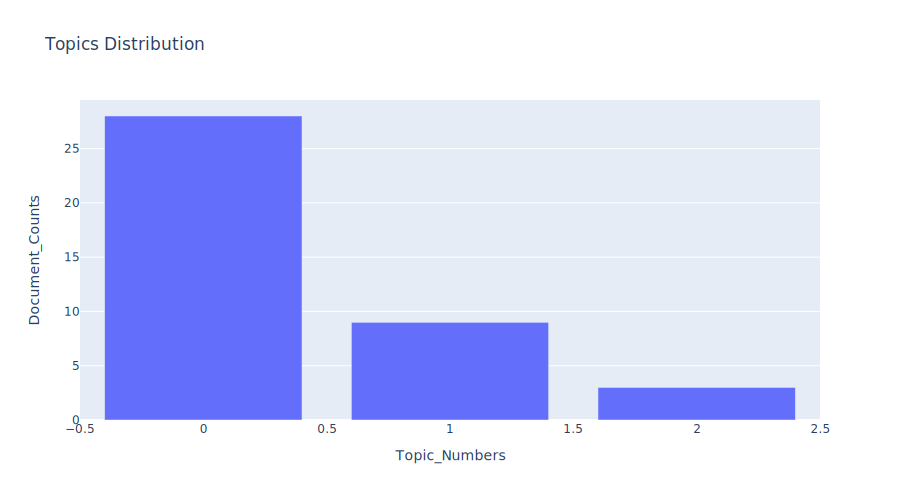

In [67]:
pre_queries_dist, fig = processor.plot_topic_distribution(pre_queries_topic_sents_keywords)
fig.show()

In [73]:
post_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=3,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='symmetric',
                                        eta='symmetric')
post_coherence_model = gensim.models.CoherenceModel(model=post_lda_model, 
                                                    texts=post_queries['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_coherence_model_score = post_coherence_model.get_coherence()
print('Post-COVID coherence Score: ', post_coherence_model_score)

Post-COVID coherence Score:  -13.982672648615116


In [74]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(post_lda_model, post_corpus, post_id2word)
LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.119772 -0.014462       1        1  40.213214
0      0.075730 -0.074759       2        1  37.405101
2      0.044042  0.089221       3        1  22.381685, topic_info=            Term      Freq     Total Category  logprob  loglift
70   transaction  9.000000  9.000000  Default  30.0000  30.0000
13          bank  6.000000  6.000000  Default  29.0000  29.0000
445        order  3.000000  3.000000  Default  28.0000  28.0000
308           rs  2.000000  2.000000  Default  27.0000  27.0000
3             id  2.000000  2.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
335         paid  1.290815  3.737535   Topic3  -4.9571   0.4338
53            ur  1.292772  4.426128   Topic3  -4.9556   0.2662
5         ticket  1.005466  2.463090   Topic3  -5.2069   0.6010
4           need  0.958191  3.147387   Topic3  -5.2551   0.3076
70   transaction  1.213025  9.754976   Topic3  -5.0193  -0.5877

[169 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
57        3  0.844362  abusingsaying
438       2  1.018134             ac
12        1  0.375198        account
12        2  0.625331        account
291       1  0.602296            add
...     ...       ...            ...
237       3  0.867508        walmart
26        1  0.755754           want
26        2  0.377877           want
269       3  0.873150           wont
246       1  0.753611          worst

[178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [75]:
post_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=post_lda_model, 
                                                         corpus=post_corpus, 
                                                         texts=post_queries['bigram'].values.tolist(),
                                                         tweets=post_queries['tweet'].values.tolist())


In [76]:
post_queries_topic_sents_keywords['Topic_Keywords'].unique()

array(['payment, order, wallet, refund, money, rs, id, cashback, wont, executive',
       'transaction, money, bank, app, help, payment, account, card, deducted, debited',
       'app, indian, use, truly_indian, payments, india, recharge, users, account, products'],
      dtype=object)

Following topics were discussed post pandemic:
1. Wallet related issues
2. Amount deductions
3. Indian payments apps promotion

In [78]:
# select = post_queries_topic_sents_keywords['Topic_Keywords'].unique()[2]
# post_queries_topic_sents_keywords[post_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



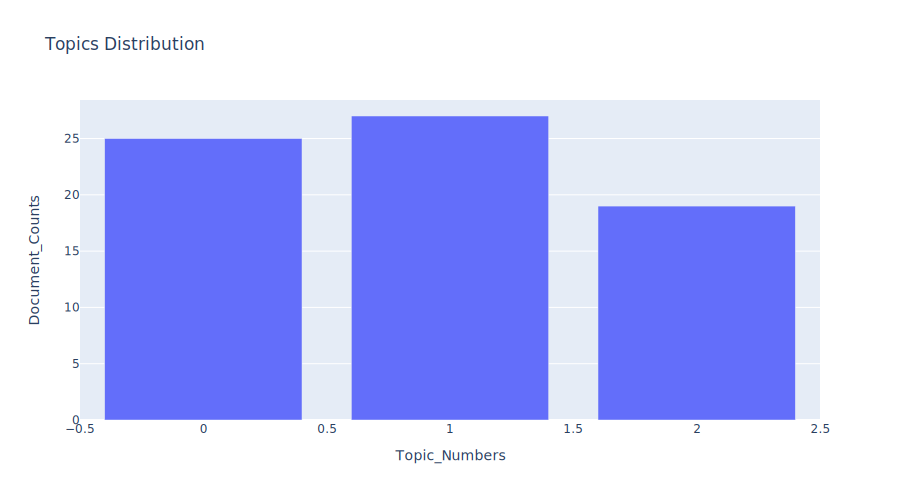

In [79]:
post_queries_dist, fig = processor.plot_topic_distribution(post_queries_topic_sents_keywords)
fig.show()